Victor CHAU & Tahar AMAIRI
# IFT 870 - Forage de données
## TP4 : Fonctions descriptives

### Sommaire
- 1. Segmentation des données suivant la longueur des séquences
    - a) Histogramme
    - b) Partitionnement
- 2. Partitionnement à partir d’une représentation vectorielle des données
    - a) Représentation vectorielle
    - b) Suppression des motifs non-fréquents
    - c) Choix du nombre de clusters pour chaque groupe
- 3. Partitionnement à partir d’une matrice de distances
    - a) Construction de la matrice de distance
    - b) K-Medoids
    - c) Choix du nombre de clusters pour chaque groupe
- 4. Analyse de la signification sémantique
    - a) K-Means
    - b) K-Medoids
    - c) Comparaison entre les deux méthodes
     
## Importation des données

In [157]:
# import libs
from sklearn.metrics import silhouette_samples, silhouette_score
from IPython.display import display
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from Bio import pairwise2
import pandas as pd
import numpy as np

In [2]:
# read CSV
df = pd.read_csv('TP4_data.csv')

# print the df
df.head()

,id,sequence
0,AAIY01303410.1/717-923,CCAACGUGGAUACUCCCGGGAGGUCACUCUCCCCGGGCUCUGUCCA...
1,CP000140.1/4143906-4143709,UACCUUUGCAUCCGAAUUGGUUCCGUACGCUCGUUCGGGCAUACGG...
2,URS0000D6BCE7_12908/1-215,GCGUAACGCGCUAUGGCUUAAACGGCUGCCCCAAAGCUGCCAAAGG...
3,X71081.1/4425-4646,CCAAUGUGGAUAUCCUUAGAGGUCUCUCUUGGGCUCUGUCCAGGUG...
4,AACY020770731.1/455-512,UUUCGUUCACCCUCAAUUGAGGGCGCAGUUCGAGUCAUACCAUGGA...


## 1. Segmentation des données suivant la longueur des séquences
### a) Histogramme

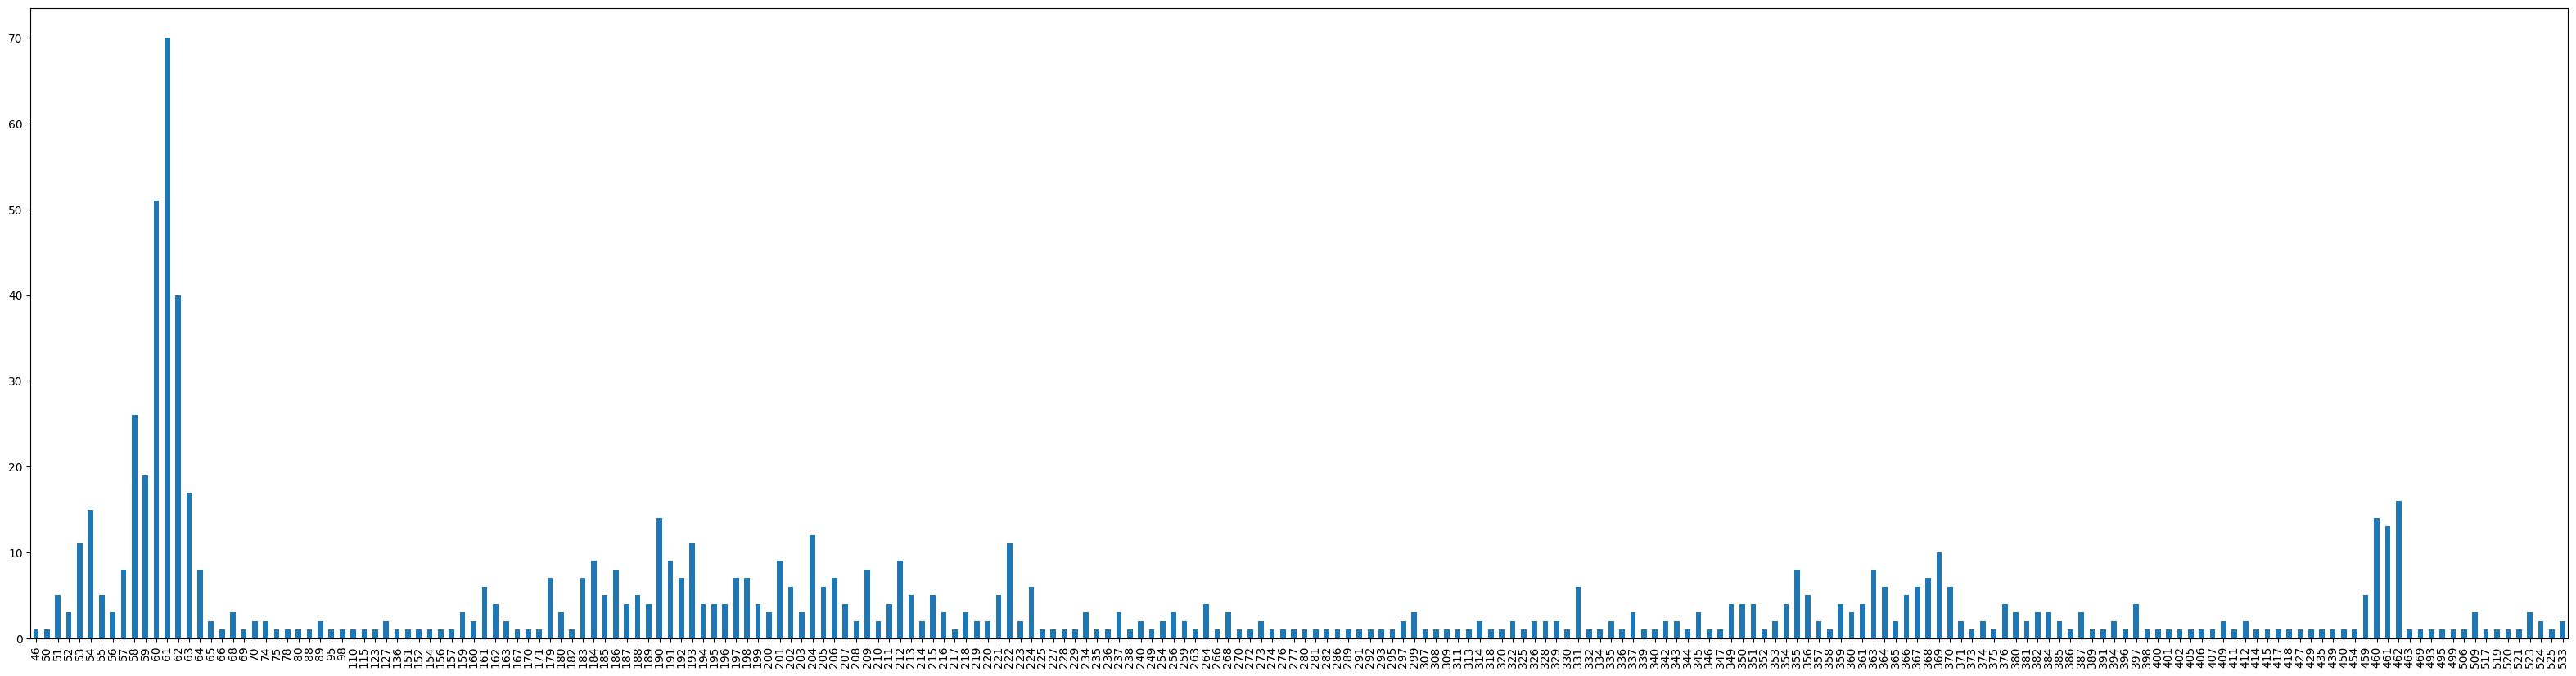

In [3]:
# plot histogram
freq = df['sequence'].str.len().value_counts()
freq = freq.loc[np.sort(freq.index)]
freq.plot(kind='bar', figsize=(40,10));

### b) Partitionnement 
COMMENT : TODO

In [4]:
# first group
mask = (df['sequence'].str.len() < 124)
df1 = df.loc[mask,:]

# second group
mask = (df['sequence'].str.len() >= 127) & (df['sequence'].str.len() < 300)
df2 = df.loc[mask,:]

# third group
mask = (df['sequence'].str.len() >= 300) & (df['sequence'].str.len() < 410)
df3 = df.loc[mask,:]

# fourth group
mask = (df['sequence'].str.len() >= 410)
df4 = df.loc[mask,:]

## 2. Partitionnement à partir d’une représentation vectorielle des données
### a) Représentation vectorielle

In [5]:
# transform a list of sequences into a k-mer vectorial representation using a list of k-mer
def SeqToKMerVec(seq, k_mer):
    # data frame containing the results
    df = pd.DataFrame(0, index=np.arange(len(seq)), columns=["{}-mer".format(k) for k in k_mer])

    # iterate over each k-mer value 
    for k in k_mer:
        # transform into a k-mer vectorial representation
        df['{}-mer'.format(k)] = seq.apply(lambda s: [s[i:i+k] for i in range(len(s)-k+1)]).values

    # return the df
    return df

# first group
dfKMerVec1 = SeqToKMerVec(df1['sequence'], [2,3,4])

# print the result
dfKMerVec1.head()

,2-mer,3-mer,4-mer
0,"[UU, UU, UC, CG, GU, UU, UC, CA, AC, CC, CC, C...","[UUU, UUC, UCG, CGU, GUU, UUC, UCA, CAC, ACC, ...","[UUUC, UUCG, UCGU, CGUU, GUUC, UUCA, UCAC, CAC..."
1,"[AU, UU, UC, CG, GU, UU, UC, CA, AC, CC, CC, C...","[AUU, UUC, UCG, CGU, GUU, UUC, UCA, CAC, ACC, ...","[AUUC, UUCG, UCGU, CGUU, GUUC, UUCA, UCAC, CAC..."
2,"[AA, AU, UC, CG, GA, AG, GA, AG, GG, GA, AA, A...","[AAU, AUC, UCG, CGA, GAG, AGA, GAG, AGG, GGA, ...","[AAUC, AUCG, UCGA, CGAG, GAGA, AGAG, GAGG, AGG..."
3,"[CC, CC, CU, UU, UG, GA, AG, GU, UA, AG, GA, A...","[CCC, CCU, CUU, UUG, UGA, GAG, AGU, GUA, UAG, ...","[CCCU, CCUU, CUUG, UUGA, UGAG, GAGU, AGUA, GUA..."
4,"[UU, UA, AA, AA, AC, CG, GA, AG, GG, GA, AU, U...","[UUA, UAA, AAA, AAC, ACG, CGA, GAG, AGG, GGA, ...","[UUAA, UAAA, AAAC, AACG, ACGA, CGAG, GAGG, AGG..."


In [6]:
# do the same for the other groups
dfKMerVec2 = SeqToKMerVec(df2['sequence'], [2,3,4])
dfKMerVec3 = SeqToKMerVec(df3['sequence'], [2,3,4])
dfKMerVec4 = SeqToKMerVec(df4['sequence'], [2,3,4])

### b) Suppression des motifs non-fréquents
COMMENT : TODO

In [7]:
# remove non frequent motif from a list of sequence using a threshold 
def removeNonFrequentMotif(seq, threshold):
    # get all the motifs
    motifs = set(seq.sum())
    # number of sequences in seq
    n = len(seq)
   
    # filter each motif
    for motif in motifs:
        # occurrence of the motif
        count = 0

        # compute the occurrence
        for l in seq.values:
            if motif in l:
                count += 1

        # if the score is less than the threshold, remove the motif
        if count / n < threshold:
            for i in range(n):
                seq.values[i] = [j for j in seq.values[i] if j != motif]

# transform the vectorial representation to a matrix
def KMerVecToMatrix(dfKMerVec, threshold):
    # the matrix containing the result 
    m = pd.DataFrame()

    for col in dfKMerVec:
        # first remove non frequent motifs
        removeNonFrequentMotif(dfKMerVec[col], threshold)
        # get the matrix for the current k-mer
        dum = pd.get_dummies(dfKMerVec[col].explode()).groupby(level=0).sum()
        # concatenate to m
        m = pd.concat([m,dum], axis=1)

    return m

# first group
m1 = KMerVecToMatrix(dfKMerVec1, 1/3)

# print the result
m1.head()

,AA,AC,AG,AU,CA,CC,CG,CU,GA,GC,...,GCAA,GCCG,GGAA,GUUC,UCGG,UGCA,UGCU,UUCA,UUGA,UUGC
0,2,3,3,4,5,3,4,1,4,3,...,0,0,1,2,0,0,0,1,1,0
1,2,3,4,5,3,4,4,2,3,4,...,0,0,1,1,0,0,0,1,0,0
2,17,2,4,5,2,1,2,3,6,3,...,1,0,1,0,0,1,1,0,1,1
3,3,2,6,1,5,8,4,3,3,7,...,0,0,1,1,0,0,1,1,1,2
4,10,2,5,4,2,1,2,5,4,4,...,1,0,0,0,0,1,1,0,0,1


In [8]:
# do the same for the other groups
m2 = KMerVecToMatrix(dfKMerVec2, 1/3)
m3 = KMerVecToMatrix(dfKMerVec3, 1/3)
m4 = KMerVecToMatrix(dfKMerVec4, 1/3)

### c) Choix du nombre de clusters pour chaque groupe

In [9]:
# plot silhouette score, adapted from : https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html
def plotSilhouetteScore(range_n_clusters, X, KMethod, KMethodParam, metric, sklearn = False):
    nPlots = len(range_n_clusters)  # number of plots
    nRows = int(np.ceil(nPlots / 3))  # number of rows for the subplots

    # create subplot
    fig, ax = plt.subplots(nrows=nRows, ncols=3, figsize=(15, 10))
    fig.tight_layout(pad=3.5)
    ax = ax.flatten()

    for i in range(nPlots):
        # get subplot and the number of clusters
        ax1 = ax[i]
        n_clusters = range_n_clusters[i]
       
        # The silhouette coefficient can range from -1 to 1
        ax1.set_xlim([-1, 1])
        # The (n_clusters+1)*10 is for inserting blank space between silhouette
        # plots of individual clusters, to demarcate them clearly.
        ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

        # get labels from the specified KMethod
        if sklearn:
            cluster_labels = KMethod(n_clusters = n_clusters, **KMethodParam).fit(X).labels_
        else:
            cluster_labels = KMethod(n_clusters = n_clusters, **KMethodParam)

        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation of the formed
        # clusters
        silhouette_avg = silhouette_score(X, cluster_labels, metric=metric)

        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(X, cluster_labels, metric=metric)
        y_lower = 10

        for i in range(n_clusters):
            # Aggregate the silhouette scores for samples belonging to
            # cluster i, and sort them
            ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_clusters)
            ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, facecolor=color, edgecolor=color, alpha=0.7)

            # Label the silhouette plots with their cluster numbers at the middle
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        ax1.set_title("Number of clusters = {}, silhouette score = {:.3f}".format(n_clusters, silhouette_avg))
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

        # The vertical line for average silhouette score of all the values
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
        ax1.set_yticks([])  # Clear the yaxis labels / ticks
        ax1.set_xticks([-1, -0.8,-0.6,-0.4,-0.2, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # remove unnecessary plot
    toRemove = (nRows * 3) - nPlots
    for i in range(toRemove):
        ax.flat[(nRows * 3) - 1 - i].set_visible(False)

In [10]:
# k values to test
range_n_clusters = list(range(2,11))
# KMeans param
param = {'n_init' : 10, 'max_iter' : 1000, 'random_state' : 0}

Pour moi, selon mon analyse, le nombre de clusters pour chaque groupe : 
- Group 1 : 6
- Group 2 : 3
- Group 3 : 2
- Group 4 : 4

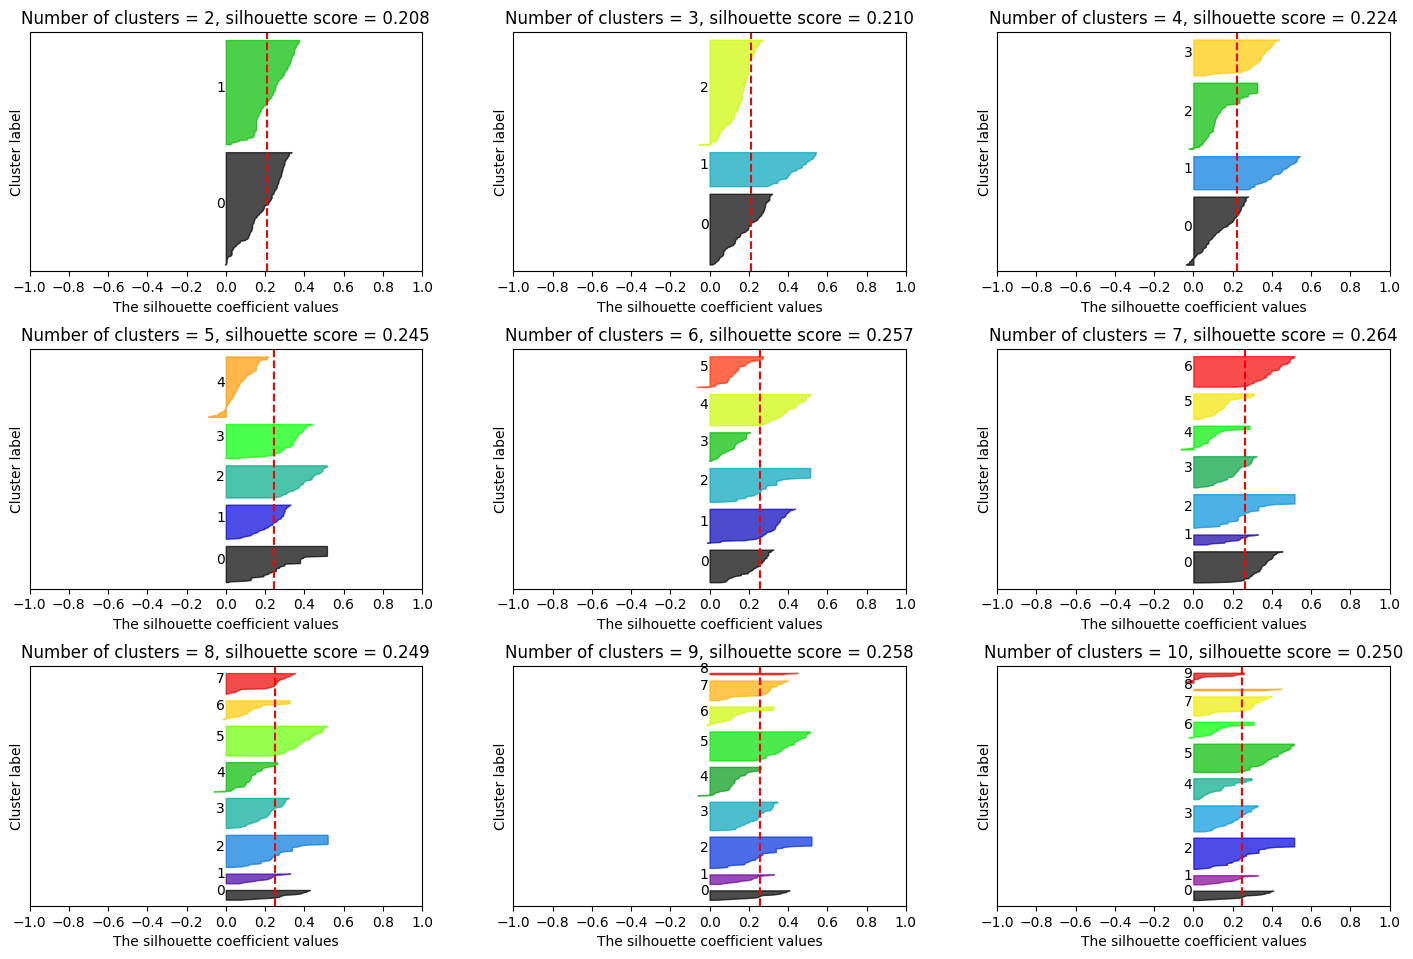

In [11]:
# first group
plotSilhouetteScore(range_n_clusters, m1.to_numpy(), KMeans, param, "euclidean", sklearn=True)

Pour l'analyse : https://towardsdatascience.com/elbow-method-is-not-sufficient-to-find-best-k-in-k-means-clustering-fc820da0631d

COMMENT : TODO

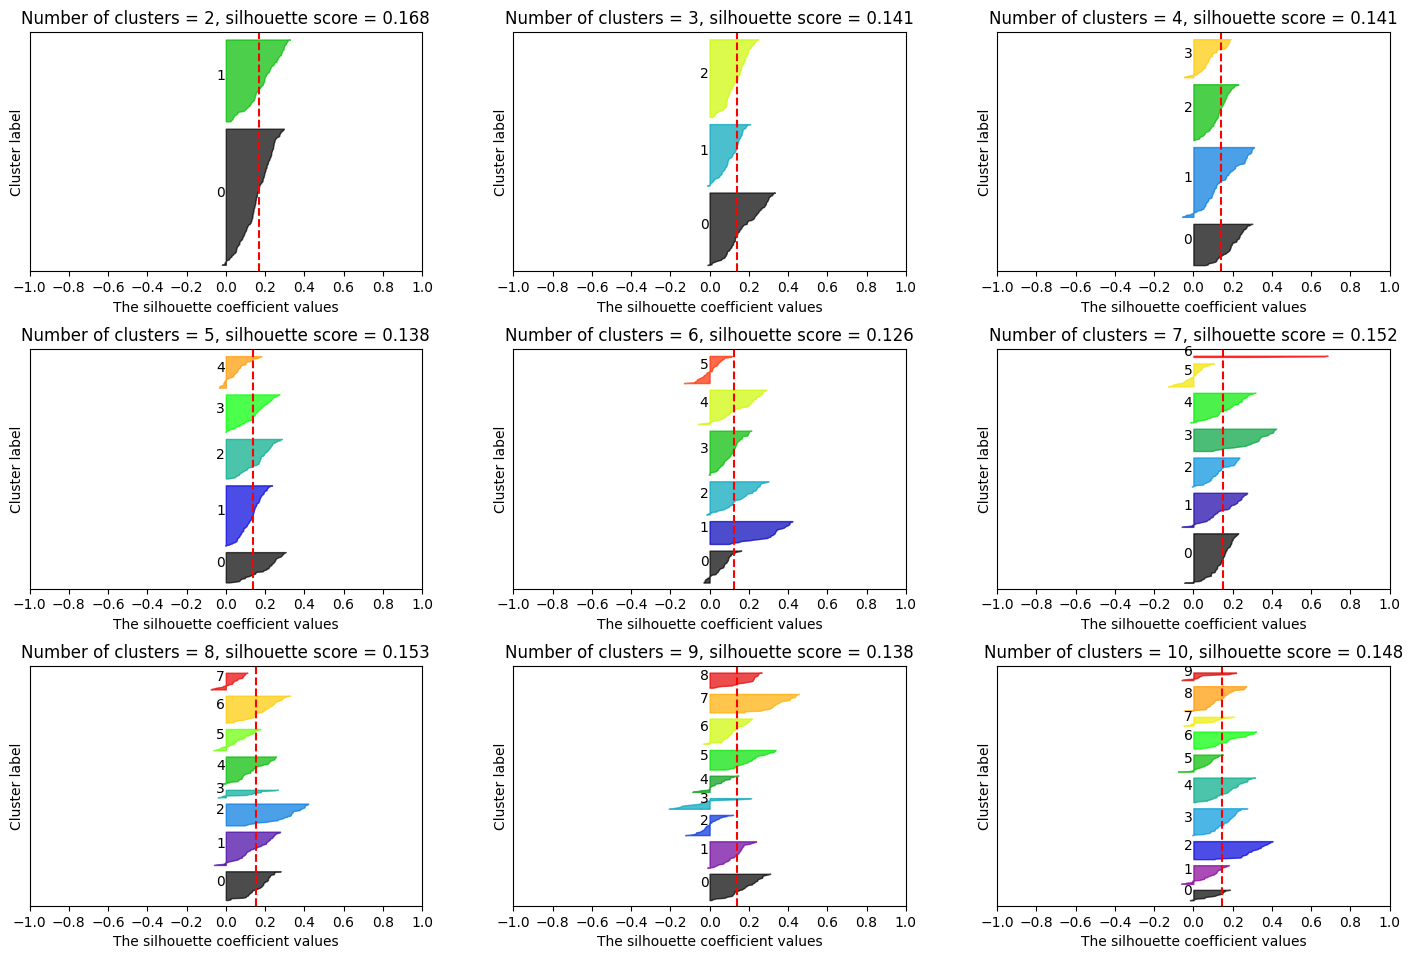

In [12]:
# second group
plotSilhouetteScore(range_n_clusters, m2.to_numpy(), KMeans, param, "euclidean", sklearn=True)

COMMENT : TODO

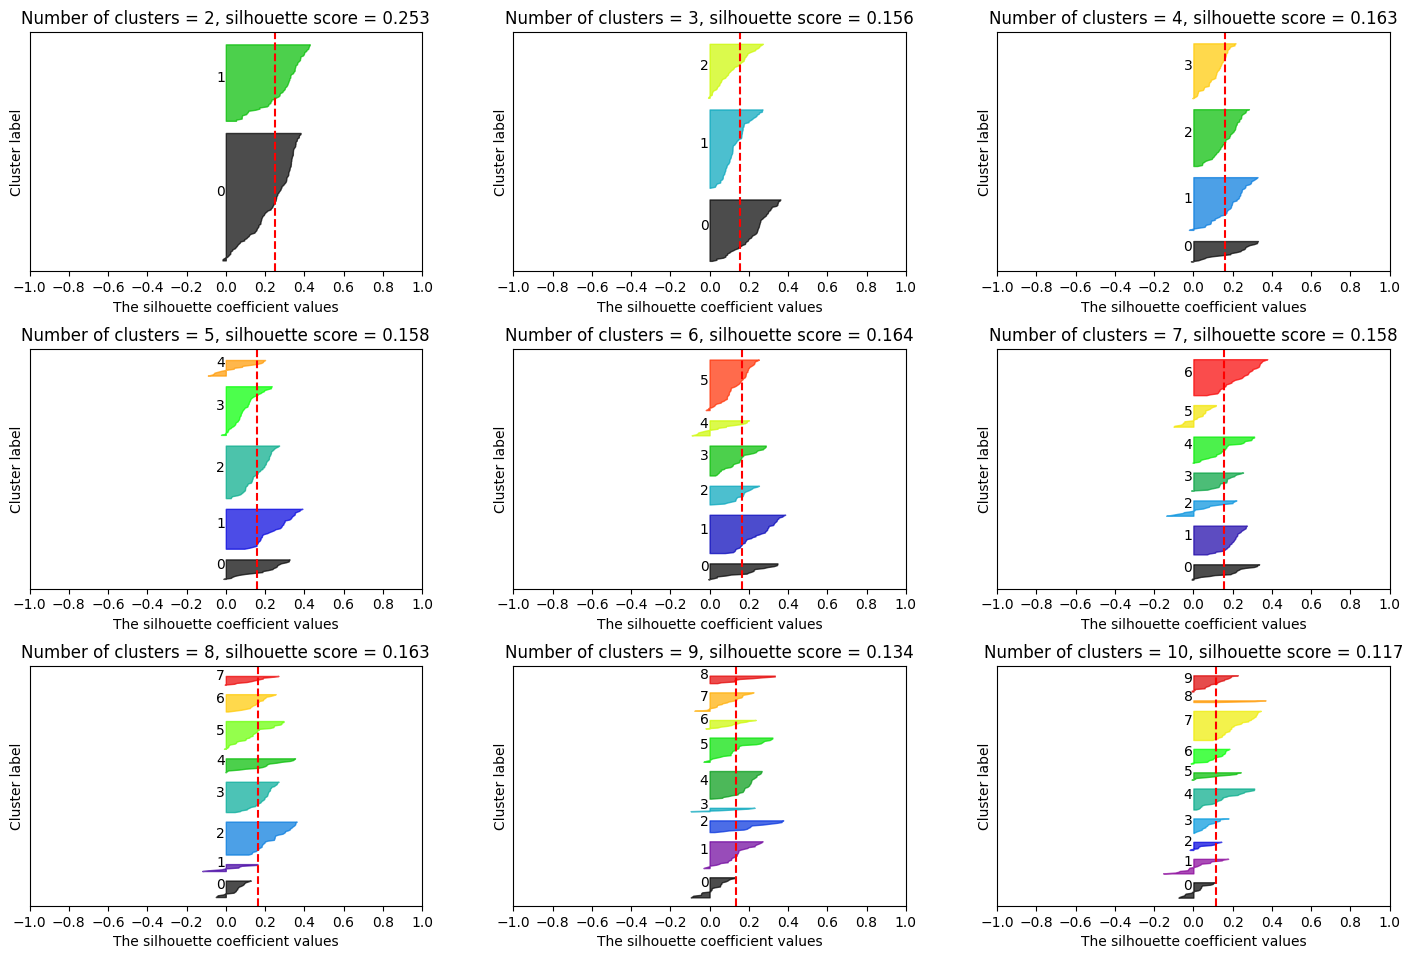

In [13]:
# third group
plotSilhouetteScore(range_n_clusters, m3.to_numpy(), KMeans, param, "euclidean", sklearn=True)

COMMENT : TODO

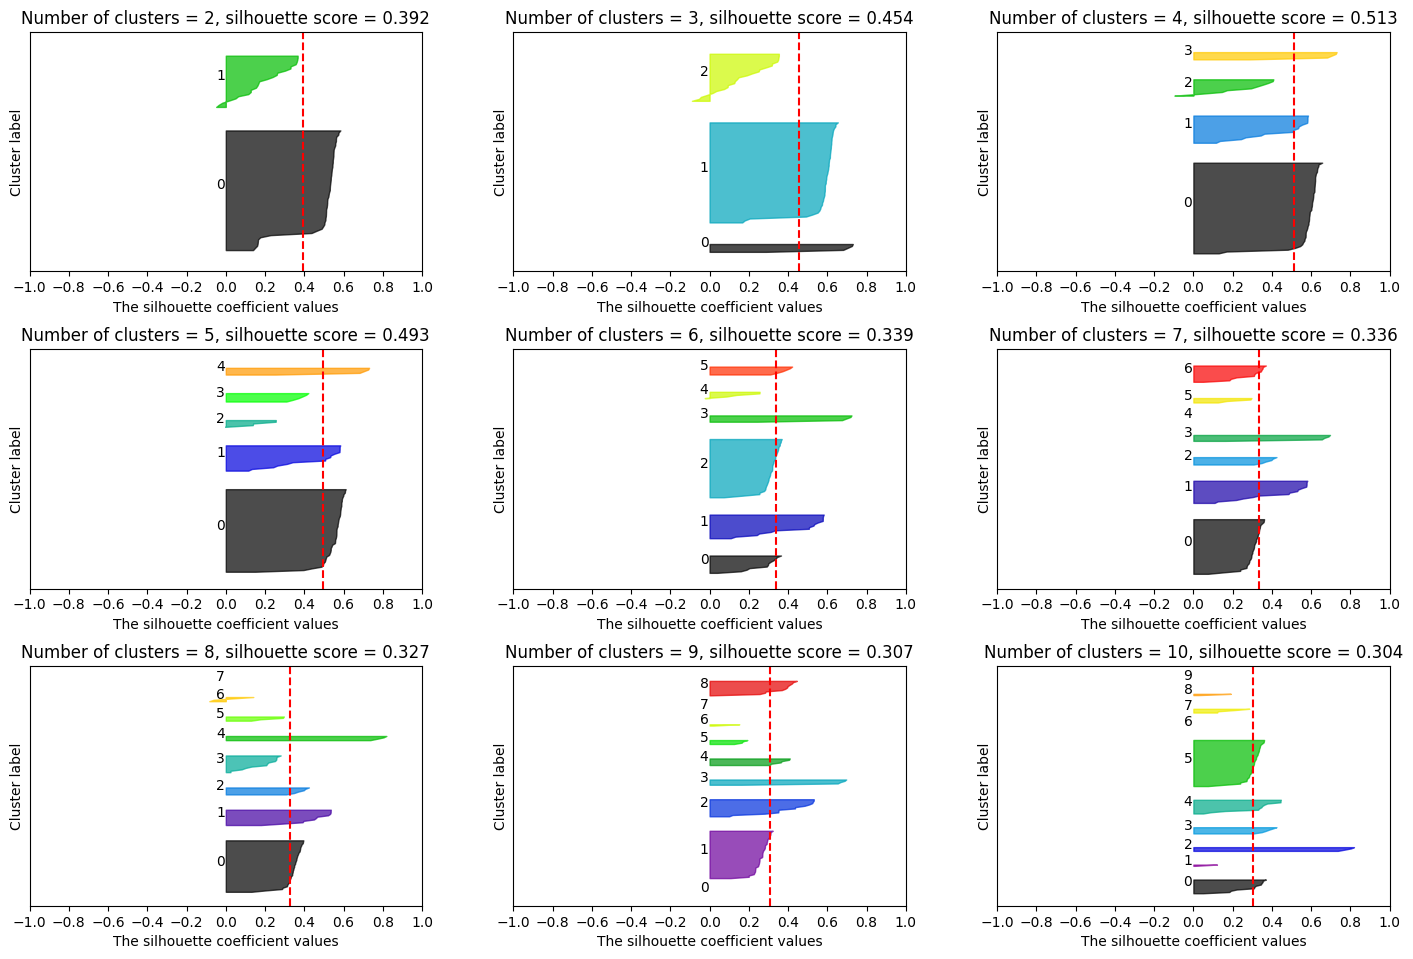

In [14]:
# fourth group
plotSilhouetteScore(range_n_clusters, m4.to_numpy(), KMeans, param, "euclidean", sklearn=True)

COMMENT : TODO
## 3. Partitionnement à partir d’une matrice de distances
### a) Construction de la matrice de distance

In [15]:
# compute the alignement between two sequences
def dist(S1, S2):
    alignment = pairwise2.align.globalxx(S1,S2)
    return alignment[0][4] - alignment[0][2]

# get the matrix of distance of a list of sequences
def getDistMatrix(seq):
    # number of sequences
    n = len(seq)
    # data frame containing the results
    df = pd.DataFrame(0.0, index=np.arange(n), columns=np.arange(n))

    # iterate over each sequence
    for i in range(n):
        S1 = seq.values[i]
        for j in range(i,n):
            df.iloc[i,j] = df.iloc[j,i] = dist(S1,seq.values[j])
  
    # return the df
    return df

# first group
dfDist1 = getDistMatrix(df1['sequence'])

# print the result
dfDist1.head()

,0,1,2,3,4,5,6,7,8,9,...,295,296,297,298,299,300,301,302,303,304
0,0.0,11.0,59.0,54.0,50.0,46.0,46.0,35.0,54.0,50.0,...,47.0,47.0,50.0,50.0,52.0,47.0,56.0,54.0,2.0,50.0
1,11.0,0.0,56.0,51.0,47.0,45.0,43.0,34.0,51.0,47.0,...,46.0,44.0,45.0,45.0,49.0,48.0,55.0,55.0,13.0,45.0
2,59.0,56.0,0.0,55.0,25.0,49.0,53.0,54.0,31.0,47.0,...,60.0,44.0,45.0,45.0,57.0,48.0,67.0,17.0,59.0,45.0
3,54.0,51.0,55.0,0.0,54.0,50.0,46.0,55.0,56.0,46.0,...,55.0,47.0,48.0,48.0,30.0,47.0,44.0,50.0,54.0,48.0
4,50.0,47.0,25.0,54.0,0.0,42.0,52.0,45.0,36.0,44.0,...,55.0,41.0,44.0,44.0,56.0,47.0,64.0,20.0,50.0,44.0


In [16]:
# do the same for the other groups
dfDist2 = getDistMatrix(df2['sequence'])
dfDist3 = getDistMatrix(df3['sequence'])
dfDist4 = getDistMatrix(df4['sequence'])

### b) K-Medoids

In [17]:
# k-medoids clustering
def KMedoid(n_clusters, X):
    # number of sequences
    n = X.shape[0]
    # check if n_clusters is less or equal to the size of X
    n_clusters = n_clusters if n_clusters <= n else n
    # pick the n_clusters points with the smallest sum distance to every other point
    medoids, prevMedoids = np.argpartition(np.sum(X, axis=1), n_clusters - 1)[:n_clusters], np.zeros(n_clusters)
    
    # loop until the medoids do not change
    while(not (medoids == prevMedoids).all()):
        # get the cluster idx for each sequences
        clusterIdx = np.argmin(X[:,medoids], axis=1)
        # cache medoids
        prevMedoids = medoids.copy()
        
        # update each medoids
        for k in range(n_clusters):
            # get sequences of the cluster k
            t = clusterIdx == k
            # get the indexes
            idx = t.nonzero()[0]

            # check if the cluster is not empty
            if len(idx) == 0:
                continue

            # to store the distance mean of each sequences of the cluster k
            l = list()

            # compute the mean distance to other sequences in the cluster k
            for i in idx:
                l.append(X[i,t].mean())

            # update the medoid as the sequence having the minimum distance
            medoids[k] = idx[np.argmin(l)]

    # return clusters
    return clusterIdx

### c) Choix du nombre de clusters pour chaque groupe

Pour moi, selon mon analyse, le nombre de clusters pour chaque groupe : 
- Group 1 : 5
- Group 2 : 4
- Group 3 : 4
- Group 4 : 8

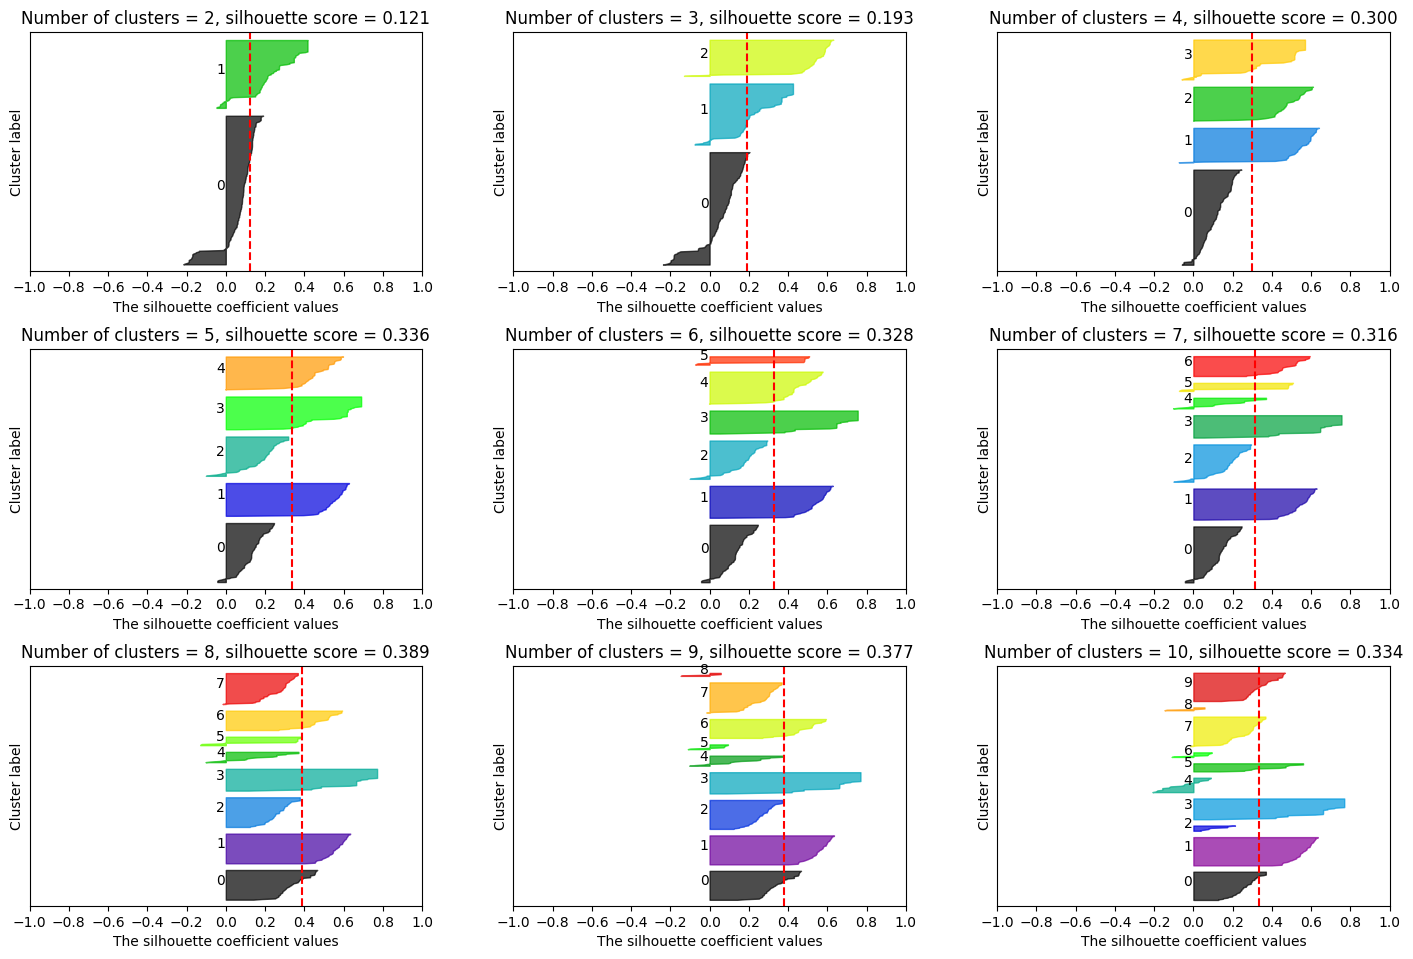

In [18]:
# first group
X = dfDist1.to_numpy()
param = {'X' : X}
plotSilhouetteScore(range_n_clusters, X, KMedoid, param, 'precomputed')

COMMENT : TODO

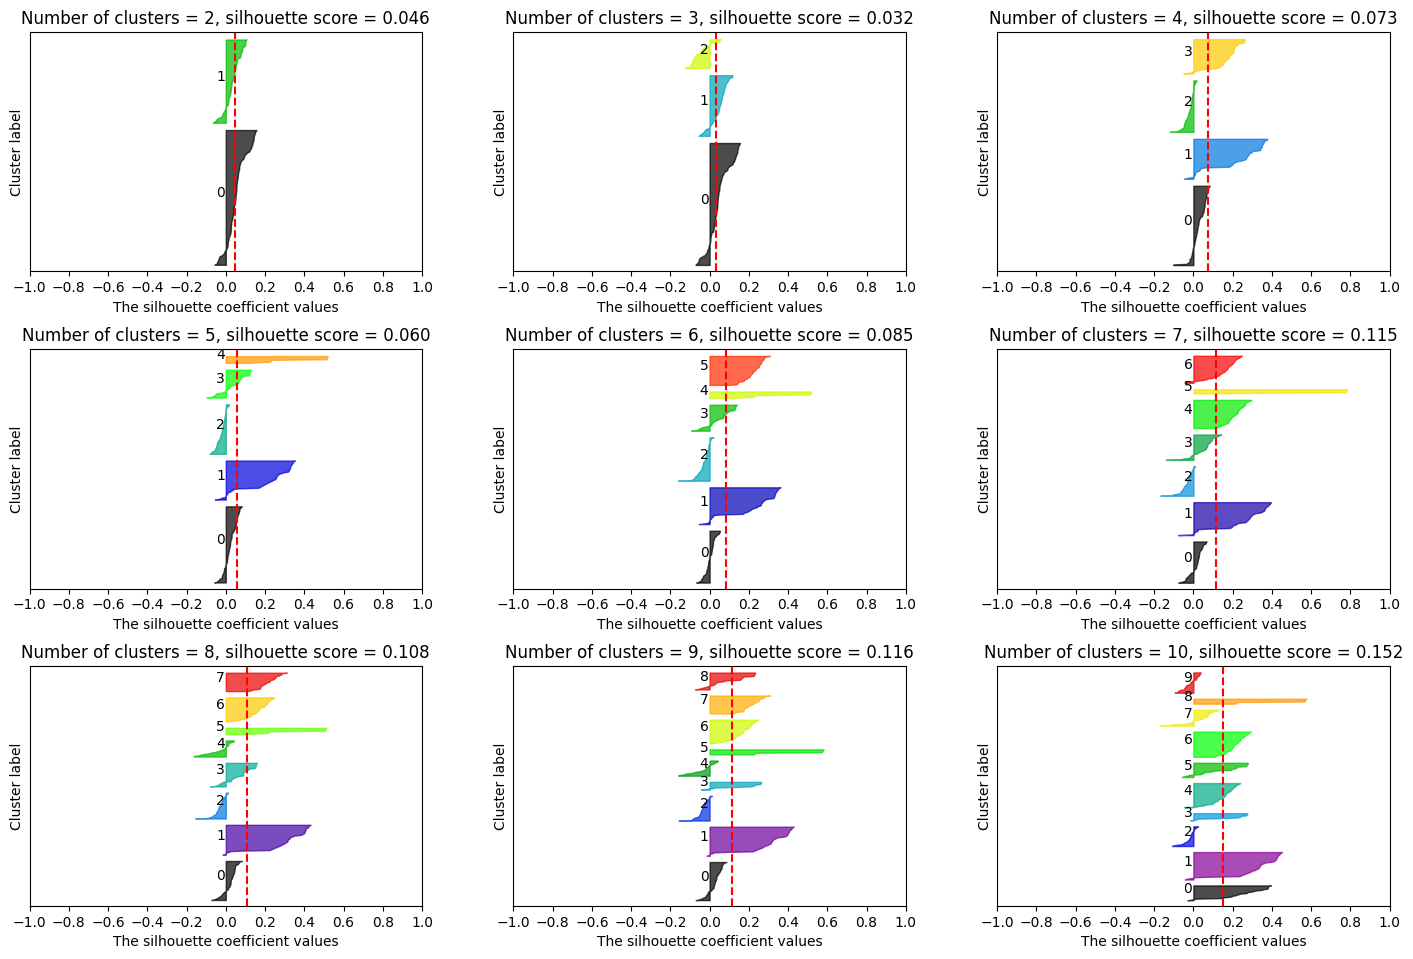

In [19]:
# second group
X = dfDist2.to_numpy()
param = {'X' : X}
plotSilhouetteScore(range_n_clusters, X, KMedoid, param, 'precomputed')

COMMENT : TODO

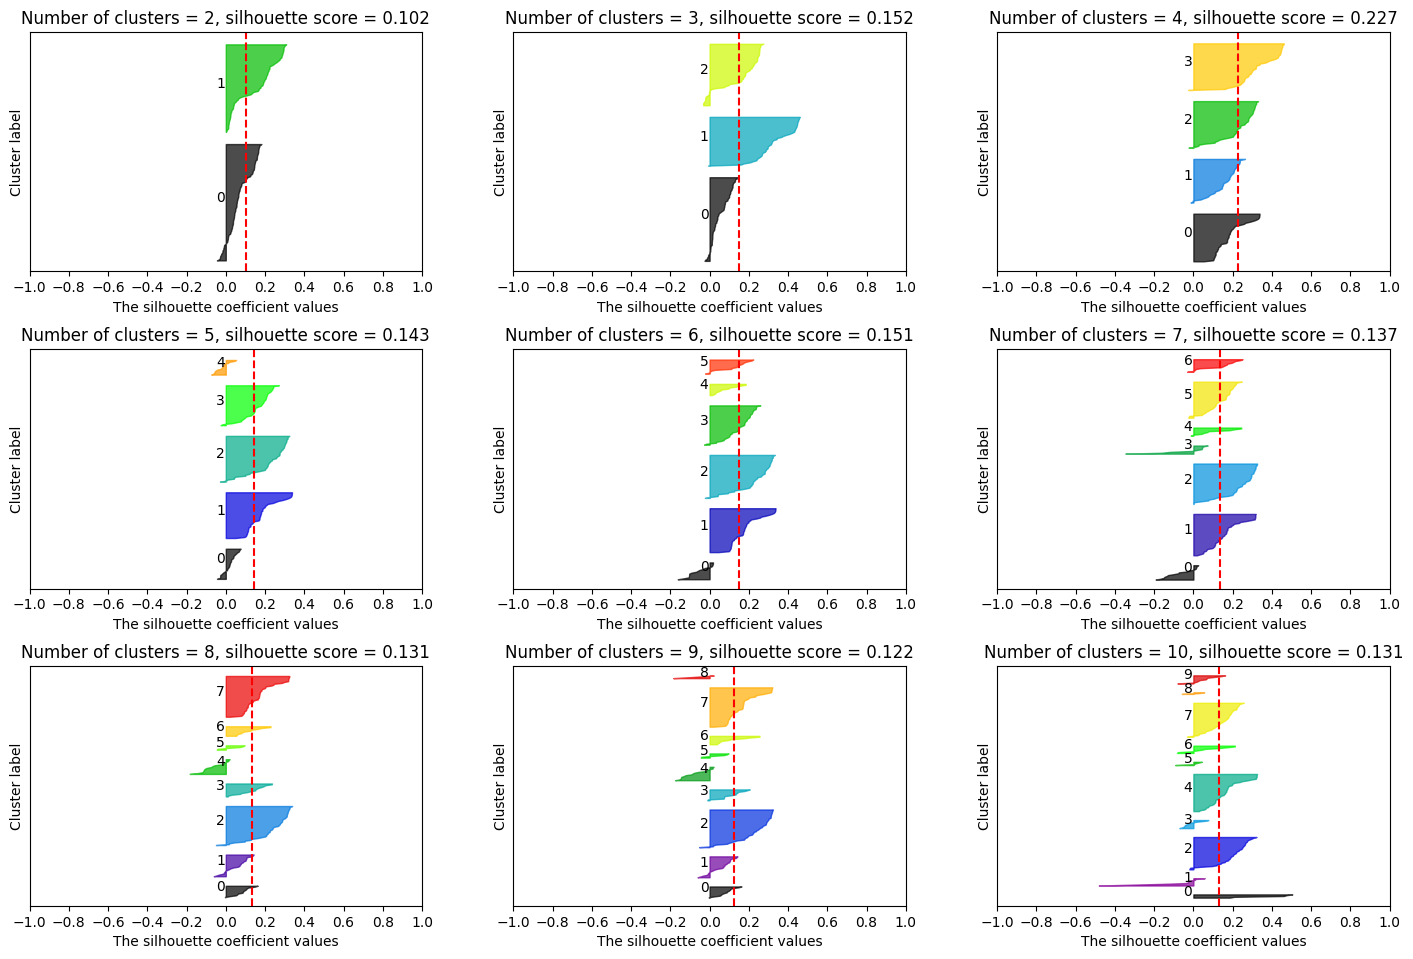

In [20]:
# third group
X = dfDist3.to_numpy()
param = {'X' : X}
plotSilhouetteScore(range_n_clusters, X, KMedoid, param, 'precomputed')

COMMENT : TODO

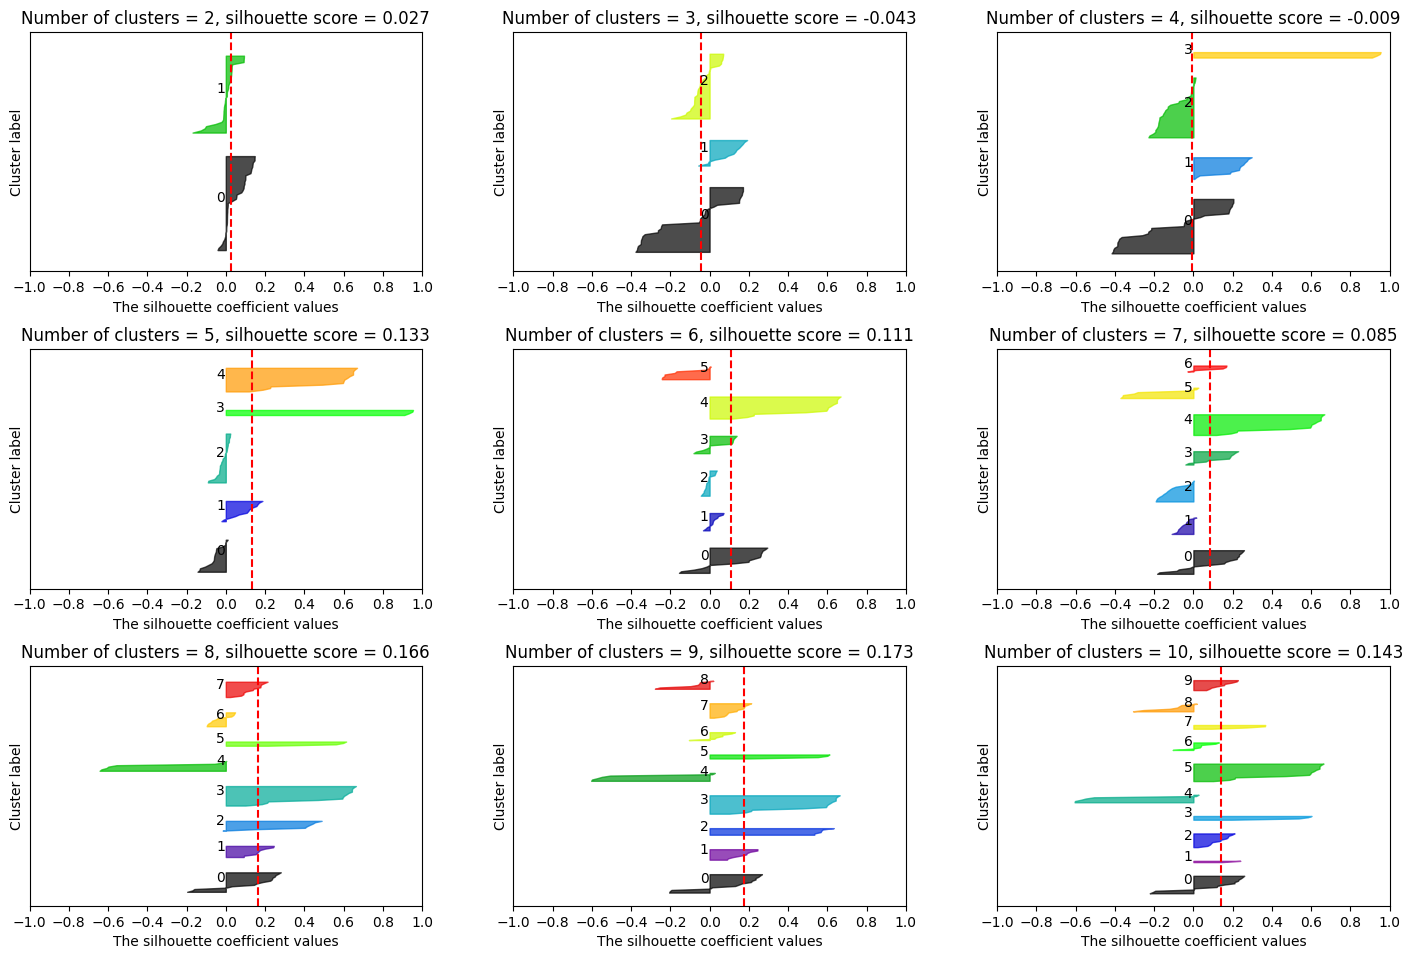

In [21]:
# forth group
X = dfDist4.to_numpy()
param = {'X' : X}
plotSilhouetteScore(range_n_clusters, X, KMedoid, param, 'precomputed')

COMMENT : TODO

## 4. Analyse de la signification sémantique
### a) K-Means

In [147]:
# for each clusters, plot its number of k-mers 
def displayClusteringMetrics(n_clusters, df, m, X, KMethod, KMethodParam, sklearn = False):
    # get labels from the specified KMethod
    if sklearn:
        cluster_labels = KMethod(n_clusters = n_clusters, **KMethodParam).fit(X).labels_
    else:
        cluster_labels = KMethod(n_clusters = n_clusters, **KMethodParam)
    
    # add clusters
    m['Cluster'] = cluster_labels
    df['Cluster'] = cluster_labels
    # group by cluster then sum motifs
    m = m.groupby(['Cluster']).sum().transpose()
    # get mean, median and std of the length
    mean = df['sequence'].str.len().groupby(df['Cluster'].values).mean()
    median = df['sequence'].str.len().groupby(df['Cluster'].values).median()
    std = df['sequence'].str.len().groupby(df['Cluster'].values).std()
    stats = pd.concat([mean.to_frame(), median.to_frame(), std.to_frame()], axis=1)
    stats.columns = ['Mean', 'Median', 'Std']
   
    # display
    for cluster in m:
        print('Cluster = {}'.format(cluster))
        sort = m[cluster].sort_values(ascending=False)
        seq = pd.DataFrame(sort.values, index=sort.index).transpose()
        st = stats.iloc[cluster,:].to_frame().transpose()
        st.index = [0]
        kmer = seq.transpose()
        kmer['kmer'] = seq.columns.str.len()
        kmer = kmer.groupby('kmer').sum().transpose()
        kmer.columns = ["{}-mer".format(i) for i in kmer]
        dfMetrics = pd.concat([seq.iloc[:,0:5], st, kmer], axis=1)
        display(dfMetrics)

In [148]:
# KMeans param
param = {'n_init' : 10, 'max_iter' : 1000, 'random_state' : 0}

Si tu n'es pas d'accord avec le nombre de clusters que j'ai choisi avant dans la partie (2.c et 3.c), il faudra adapter le code en bas en changeant le paramètre n_clusters dans la fonction displayClusteringMetrics.

In [149]:
# first group
displayClusteringMetrics(6, df1.copy(), m1.copy(), m1.to_numpy(), KMeans, param, sklearn=True)

Cluster = 0


,CG,CC,GC,GG,UG,Mean,Median,Std,2-mer,3-mer,4-mer
0,363,349,334,331,273,63.346154,60.0,13.110218,3242,3190,410


Cluster = 1


,AU,CA,AA,UA,UG,Mean,Median,Std,2-mer,3-mer,4-mer
0,318,310,304,291,278,62.203704,61.0,8.548154,3305,3251,863


Cluster = 2


,AA,GC,AU,CG,UA,Mean,Median,Std,2-mer,3-mer,4-mer
0,404,287,278,263,251,61.055556,62.0,1.43299,3243,3189,763


Cluster = 3


,AG,GC,CA,GU,CG,Mean,Median,Std,2-mer,3-mer,4-mer
0,256,253,212,206,200,57.847826,54.5,6.937715,2615,2569,564


Cluster = 4


,AA,AAA,GA,UU,UG,Mean,Median,Std,2-mer,3-mer,4-mer
0,637,389,255,245,240,60.32,60.0,2.307397,2966,2916,771


Cluster = 5


,GG,CA,UC,GA,CG,Mean,Median,Std,2-mer,3-mer,4-mer
0,328,243,230,218,215,61.040816,59.0,7.945017,2942,2893,422


COMMENT : TODO

In [150]:
# second group
displayClusteringMetrics(3, df2.copy(), m2.copy(), m2.to_numpy(), KMeans, param, sklearn=True)

Cluster = 0


,GG,CC,GC,CG,GA,Mean,Median,Std,2-mer,3-mer,4-mer
0,2304,2127,2013,1899,1708,216.714286,206.0,31.458661,24156,24042,23259


Cluster = 1


,UU,UG,AU,CU,UC,Mean,Median,Std,2-mer,3-mer,4-mer
0,1765,1647,1512,1434,1400,211.726316,201.0,30.095395,20014,19917,19443


Cluster = 2


,AA,UA,AG,UG,GU,Mean,Median,Std,2-mer,3-mer,4-mer
0,2750,1692,1690,1676,1586,193.441667,190.0,26.667828,23091,22970,22412


COMMENT : TODO

In [151]:
# third group
displayClusteringMetrics(2, df3.copy(), m3.copy(), m3.to_numpy(), KMeans, param, sklearn=True)

Cluster = 0


,GG,GC,CG,CC,AA,Mean,Median,Std,2-mer,3-mer,4-mer
0,4338,3675,3540,3221,2947,362.448276,362.0,20.065694,41924,41807,41669


Cluster = 1


,AA,AG,UU,UA,GA,Mean,Median,Std,2-mer,3-mer,4-mer
0,2688,1952,1847,1846,1827,356.214286,364.0,24.442712,24863,24793,24678


COMMENT : TODO

In [152]:
# fourth group
displayClusteringMetrics(4, df4.copy(), m4.copy(), m4.to_numpy(), KMeans, param, sklearn=True)

Cluster = 0


,AC,GG,CC,CU,UG,Mean,Median,Std,2-mer,3-mer,4-mer
0,2122,1914,1852,1797,1632,460.078431,461.0,7.036599,23413,23362,23232


Cluster = 1


,GG,UU,UG,GU,UC,Mean,Median,Std,2-mer,3-mer,4-mer
0,875,661,633,629,590,507.4375,522.0,31.832832,8103,8087,7983


Cluster = 2


,GG,GC,CG,CC,AG,Mean,Median,Std,2-mer,3-mer,4-mer
0,499,429,422,343,312,425.7,417.5,16.19362,4247,4237,4186


Cluster = 3


,AA,UA,UU,AU,GU,Mean,Median,Std,2-mer,3-mer,4-mer
0,282,246,233,199,157,510.0,509.0,4.123106,2545,2540,2438


COMMENT : TODO

### b) K-Medoids

Same here, si tu n'es pas d'accord avec le nombre de clusters que j'ai choisi avant dans la partie (2.c et 3.c), il faudra adapter le code en bas en changeant le paramètre n_clusters dans la fonction displayClusteringMetrics.

In [153]:
# first group
X = dfDist1.to_numpy()
param = {'X' : X}
displayClusteringMetrics(5, df1.copy(), m1.copy(), X, KMedoid, param)

Cluster = 0


,GG,CG,CC,GC,UC,Mean,Median,Std,2-mer,3-mer,4-mer
0,584,525,478,459,416,61.604396,60.0,10.362195,5515,5424,754


Cluster = 1


,AU,AA,CA,UA,UG,Mean,Median,Std,2-mer,3-mer,4-mer
0,296,292,289,273,252,61.019608,61.0,0.140028,3061,3010,820


Cluster = 2


,AG,GC,CA,GG,CG,Mean,Median,Std,2-mer,3-mer,4-mer
0,321,308,279,266,264,59.245902,58.0,7.934431,3553,3492,722


Cluster = 3


,AA,AU,GC,CG,UA,Mean,Median,Std,2-mer,3-mer,4-mer
0,371,277,273,254,241,61.705882,62.0,4.965054,3096,3045,715


Cluster = 4


,AA,AAA,GA,UG,UU,Mean,Median,Std,2-mer,3-mer,4-mer
0,642,389,262,252,249,61.54902,60.0,9.069319,3088,3037,782


COMMENT : TODO

In [154]:
# second group
X = dfDist2.to_numpy()
param = {'X' : X}
displayClusteringMetrics(4, df2.copy(), m2.copy(), X, KMedoid, param)

Cluster = 0


,AA,GA,UG,GG,AG,Mean,Median,Std,2-mer,3-mer,4-mer
0,2435,1868,1862,1791,1783,201.190476,197.5,30.161357,25215,25085,24410


Cluster = 1


,GG,CC,UG,CU,CA,Mean,Median,Std,2-mer,3-mer,4-mer
0,1224,1152,1103,1005,951,220.140625,212.0,25.789666,14025,13961,13646


Cluster = 2


,AA,GG,GA,UG,AG,Mean,Median,Std,2-mer,3-mer,4-mer
0,1458,1274,1263,1246,1177,206.841463,195.5,38.491452,16877,16794,16271


Cluster = 3


,GU,UU,UG,AA,AU,Mean,Median,Std,2-mer,3-mer,4-mer
0,958,874,809,762,750,203.618182,195.0,20.552995,11144,11089,10787


COMMENT : TODO

In [155]:
# third group
X = dfDist3.to_numpy()
param = {'X' : X}
displayClusteringMetrics(4, df3.copy(), m3.copy(), X, KMedoid, param)

Cluster = 0


,AA,GG,GC,CG,AG,Mean,Median,Std,2-mer,3-mer,4-mer
0,1390,1379,1367,1304,1134,358.958333,363.0,19.891149,17180,17132,17073


Cluster = 1


,GG,GC,AG,CC,CG,Mean,Median,Std,2-mer,3-mer,4-mer
0,1783,1392,1364,1242,1212,364.590909,360.5,26.162567,15998,15954,15899


Cluster = 2


,GG,CG,GC,AA,CC,Mean,Median,Std,2-mer,3-mer,4-mer
0,1639,1372,1365,1219,1195,351.957447,354.0,17.381846,16491,16443,16378


Cluster = 3


,AA,AG,GA,UG,UA,Mean,Median,Std,2-mer,3-mer,4-mer
0,1875,1379,1367,1247,1224,365.212766,369.0,21.870107,17118,17071,16997


COMMENT : TODO

In [156]:
# fourth group
X = dfDist4.to_numpy()
param = {'X' : X}
displayClusteringMetrics(8, df4.copy(), m4.copy(), X, KMedoid, param)

Cluster = 0


,AC,GG,AA,CC,UU,Mean,Median,Std,2-mer,3-mer,4-mer
0,577,531,522,511,504,468.933333,460.0,18.583659,7019,7004,6914


Cluster = 1


,AC,GG,CC,CU,UG,Mean,Median,Std,2-mer,3-mer,4-mer
0,376,341,337,313,299,461.555556,462.0,0.527046,4145,4136,4116


Cluster = 2


,AC,GG,CU,CC,UG,Mean,Median,Std,2-mer,3-mer,4-mer
0,325,304,290,287,263,460.125,460.0,0.991031,3673,3665,3655


Cluster = 3


,GG,UU,UG,GU,UC,Mean,Median,Std,2-mer,3-mer,4-mer
0,840,617,588,575,556,508.266667,523.0,32.770777,7609,7594,7497


Cluster = 4


,AA,AC,GG,CU,CC,Mean,Median,Std,2-mer,3-mer,4-mer
0,316,297,284,273,268,474.25,462.5,20.686434,3786,3778,3712


Cluster = 5


,AC,GG,CU,CC,CA,Mean,Median,Std,2-mer,3-mer,4-mer
0,182,158,157,139,127,460.5,460.0,1.0,1838,1834,1827


Cluster = 6


,AC,GG,CU,CC,UG,Mean,Median,Std,2-mer,3-mer,4-mer
0,472,416,404,403,369,461.363636,462.0,0.924416,5064,5053,5039


Cluster = 7


,GG,CG,GC,AG,GA,Mean,Median,Std,2-mer,3-mer,4-mer
0,558,472,469,394,381,432.166667,417.5,30.721131,5174,5162,5079


COMMENT : TODO

### c) Comparaison entre les deux méthodes
COMMENT : TODO